In [1]:
from a_mps import *
from b_model import *
from c_tebd import *

import matplotlib.pyplot as plt

import pickle as pkl

In [2]:
def save(filename, dict):
    with open(filename, 'wb') as f:
        pkl.dump(dict, f)

def load(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

**(a)**

In [3]:
L = 14
sx, sz = np.array([[0, 1],[1, 0]]), np.array([[1, 0], [0, -1]])

In [4]:
spinup_mps = init_spinup_MPS(L)
spinup_mps.site_expectation_value(sx), spinup_mps.site_expectation_value(sz)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

**(b)**

In [5]:
def init_spinright_MPS(L):
    """Return a product state with all spins up in the x-basis as an MPS"""
    B = np.zeros([1, 2, 1], float)
    B[0, :, 0] = 1/np.sqrt(2)
    S = np.ones([1], float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return MPS(Bs, Ss)

In [6]:
spinright_mps = init_spinright_MPS(L)
spinright_mps.site_expectation_value(sx), spinright_mps.site_expectation_value(sz)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

**(c)**

In [7]:
L, J, gs = 14, 1, [0.5, 1, 1.5]
print('         spinup, spinright')
for g in gs:
    H = TFIModel(L, J, g)
    print('g=',g,':', H.energy(spinup_mps), H.energy(spinright_mps))

         spinup, spinright
g= 0.5 : -7.0 -12.999999999999996
g= 1 : -14.0 -12.999999999999996
g= 1.5 : -21.0 -12.999999999999996


**(d)**

In [8]:
L, J, g = 14, 1, 1
example_TEBD_gs_finite(L, J, g)

finite TEBD, (imaginary time evolution)
L=14, J=1.0, g=1.00
dt = 0.10000: E = -17.4149126671984
dt = 0.01000: E = -17.4657339106461
dt = 0.00100: E = -17.4704766397477
dt = 0.00010: E = -17.4709480543445
dt = 0.00001: E = -17.4709952214514
final bond dimensions:  [2, 4, 8, 16, 21, 24, 24, 24, 21, 16, 8, 4, 2]
Exact diagonalization: E = -17.4710040547318
relative error:  5.05596606248944e-07


(-17.470995221451425,
 <b_model.TFIModel at 0x7fab248d2b60>)

**(e)**

In [9]:
def run_TEBD1_and_measure(psi, op, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1
    assert len(U_bonds) == Nbonds

    Ms = list()
    Ss = np.zeros((N_steps, psi.L - 1))
    for step in range(N_steps):

        for k in [0, 1]:
            
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)

        # measure magnetization
        M = sum(psi.site_expectation_value(op))
        Ms.append(M)

        # measure entropies for different cuts
        S_list = list()
        for n in range(psi.L - 1):

            S = psi.entanglement_entropy()[n]
            S_list.append(S)
        Ss[step, :] = S_list

    return Ms, Ss

In [10]:
def global_quench(psi, model, t, dt, chi_max, eps=1.e-10, tebd_order=1):

    assert tebd_order in [1, 2]

    U_bonds = calc_U_bonds(model, 1j*dt)
    N_steps = round(t/dt)
    op = model.sigmaz

    if tebd_order == 1:
        Ms, Ss = run_TEBD1_and_measure(psi, op, U_bonds, N_steps, chi_max, eps)
    else:
        U_bonds_half_dt = calc_U_bonds(model, 1j*dt/2)
        Ms, Ss = run_TEBD2_and_measure(psi, op, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps)

    return Ms, Ss

In [11]:
def plot_global_quench(Ms, Ss, model, t, dt, chi_max):

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
    N_steps = round(t/dt)
    ts = np.linspace(dt, t, N_steps)
    ax0.plot(ts, Ms, '-', color='tab:blue')
    ax1.plot(ts, Ss, '-', color='tab:orange')
    ax0.set_xlabel("$t$"), ax0.set_ylabel("magnetization"), ax0.grid()
    ax1.set_xlabel("$t$"), ax1.set_ylabel("half-chain entropy"), ax1.grid()
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle('$L=%d$, $\mathcal{J}=%.1f$, $g=%.1f$, $t=%.1f\,\mathcal{J}$, $\Delta t=%.2f\,\mathcal{J}$, $\chi_{\mathrm{max}}=%d$'%(model.L, model.J, model.g, t, dt, chi_max), fontsize="x-large");

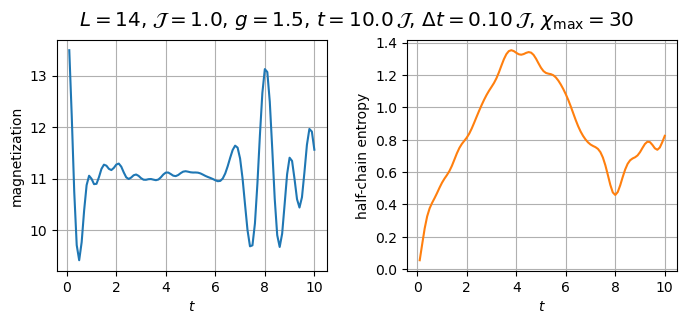

In [12]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
dt = 0.1*J
chi_max = 30
spinup_mps = init_spinup_MPS(L)
Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max)

plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

**(f)**

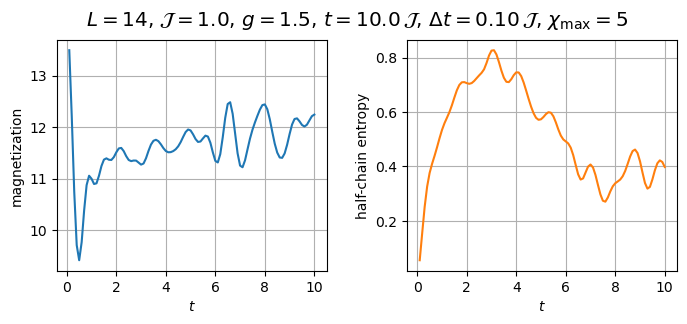

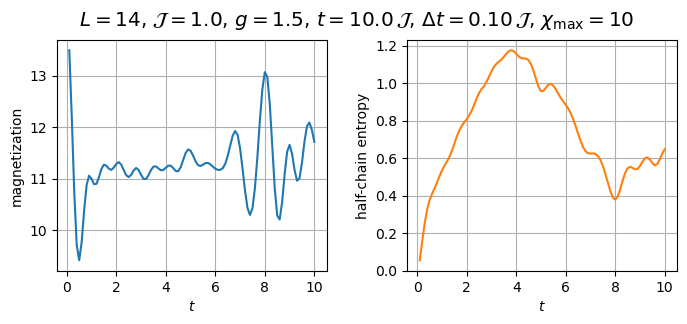

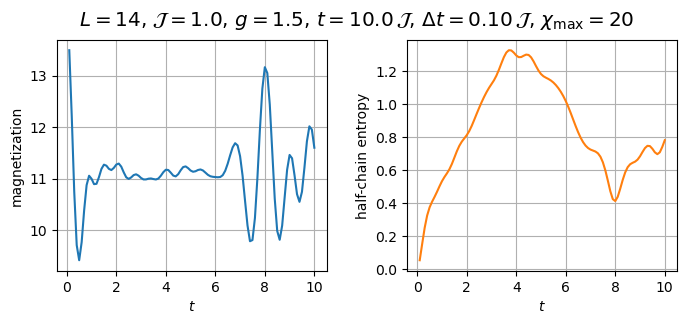

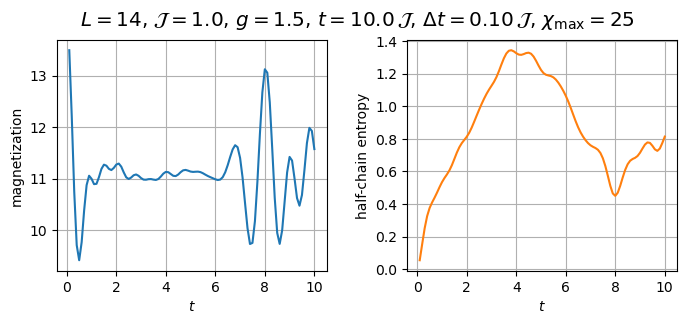

In [13]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
dt = 0.1*J
for chi_max in [5, 10, 20, 25]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

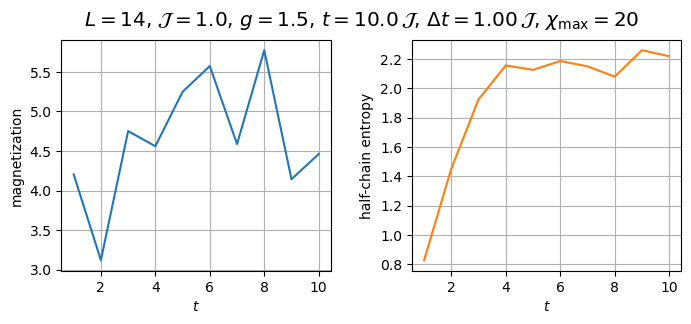

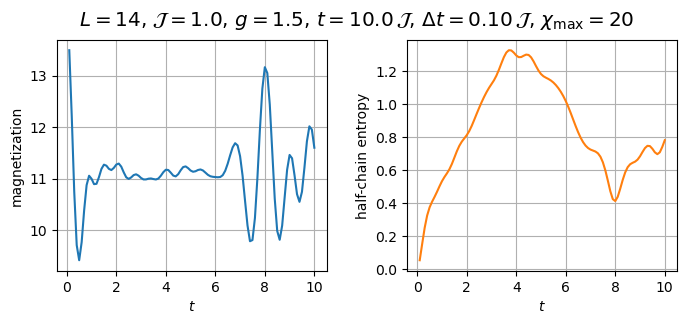

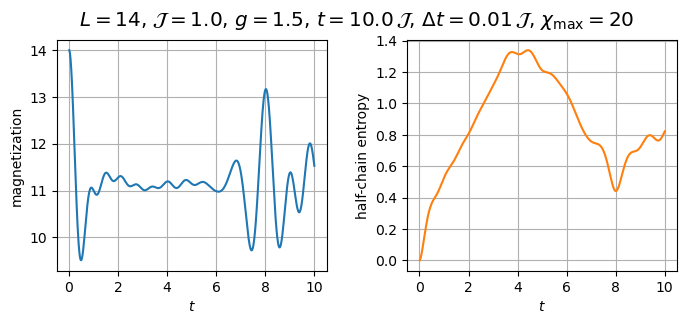

In [14]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
chi_max = 20
for dt in [1*J, 0.1*J, 0.01*J]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max)
    
    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

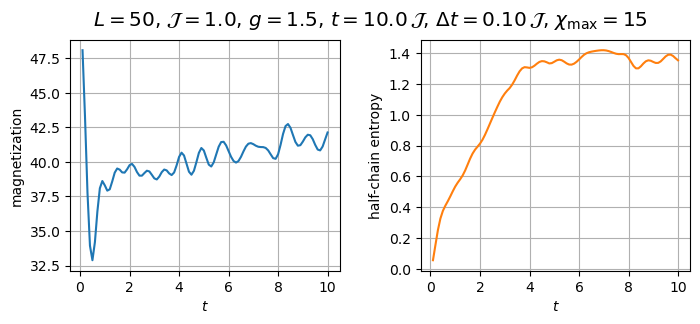

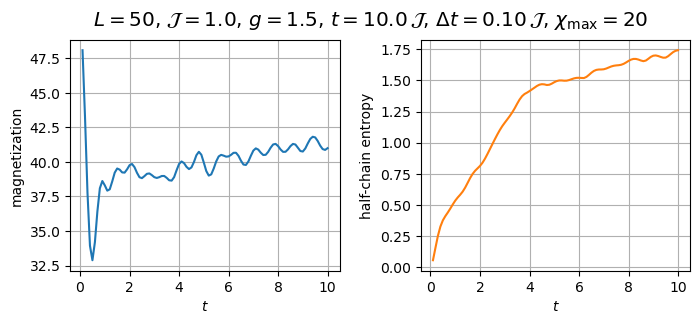

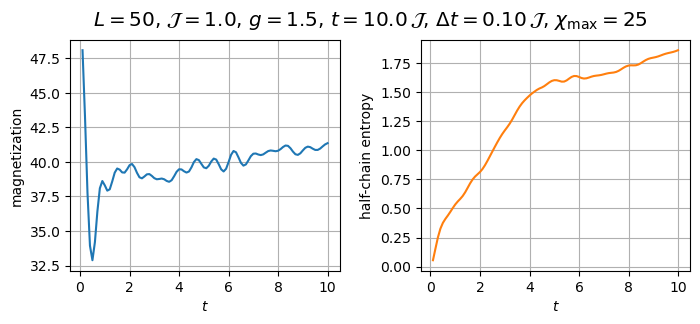

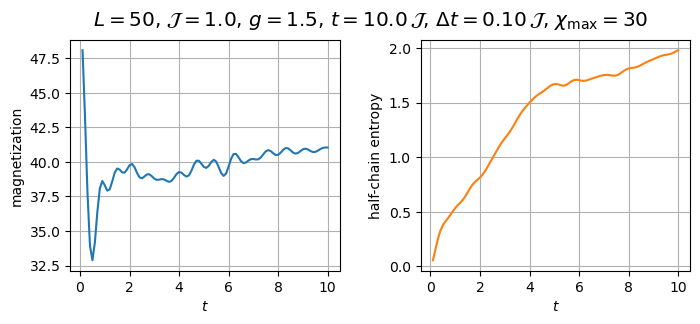

In [15]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
dt = 0.1*J
for chi_max in [15, 20, 25, 30]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

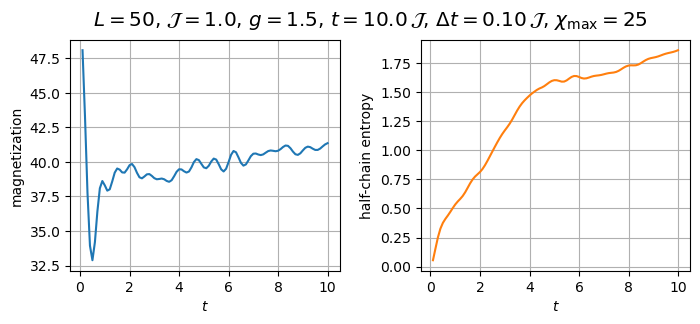

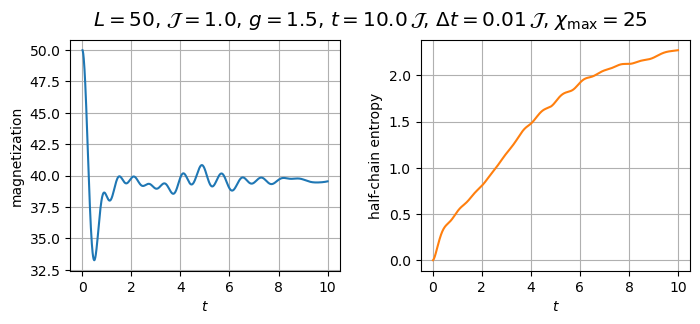

In [16]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
chi_max = 25
for dt in [0.1*J, 0.01*J]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

**(g)**

Note that the TEBD implementation applies first an even unitary and then an odd. Hence, for proper comparison, I do the same for the second-order TEBD, which differs from the formula in the manual by interchanging odd and even terms, i.e. the second-order trotterized time evolution for 3 steps is given by  
$$ U_{O}^{1/2} \, U_{E} \, U_{O}^{1/2} \, U_{O}^{1/2} \, U_{E} \, U_{O}^{1/2} \, U_{O}^{1/2} \, U_{E} \, U_{O}^{1/2}$$

In [17]:
def run_TEBD2_and_measure(psi, op, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps):

    Nbonds = psi.L - 1
    assert len(U_bonds) == Nbonds

    Ms = list()
    Ss = np.zeros((N_steps, psi.L - 1))
    for step in range(N_steps):

        for k in [0, 1, 0]:

            for i_bond in range(k, Nbonds, 2):
                U_bond = U_bonds_half_dt[i_bond] if k == 0 else U_bonds[i_bond]
                update_bond(psi, i_bond, U_bond, chi_max, eps)

        # measure magnetization
        M = sum(psi.site_expectation_value(op))
        Ms.append(M)

        # measure entropies for different cuts
        S_list = list()
        for n in range(psi.L - 1):

            S = psi.entanglement_entropy()[n]
            S_list.append(S)
        Ss[step, :] = S_list

    return Ms, Ss

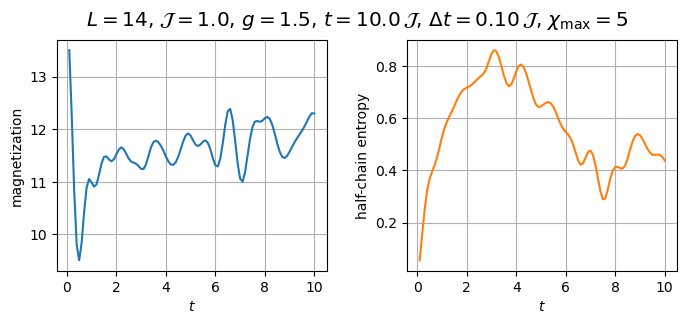

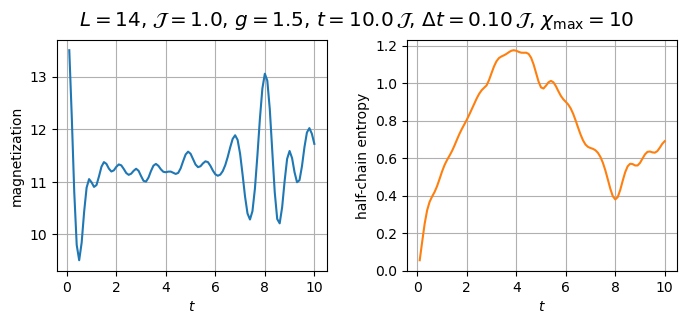

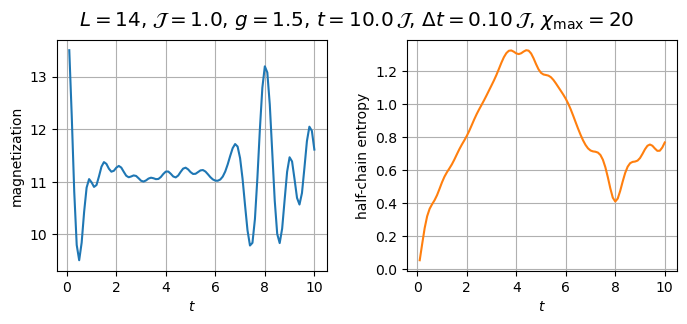

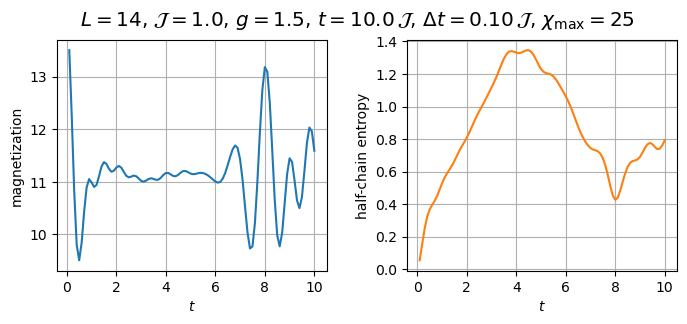

In [18]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
dt = 0.1*J
for chi_max in [5, 10, 20, 25]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max, tebd_order=2)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

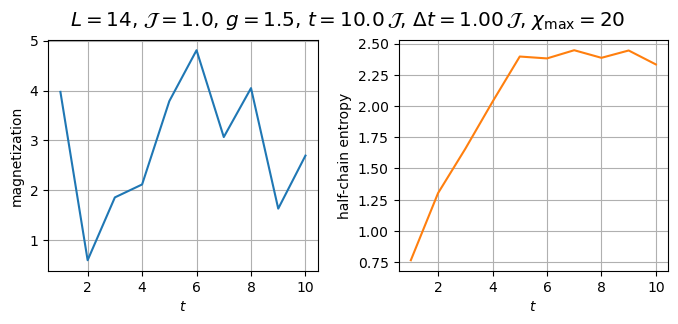

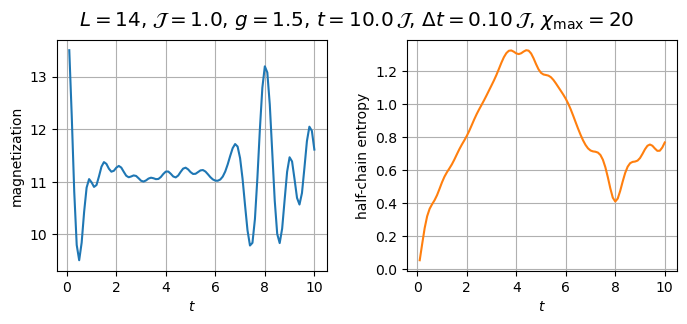

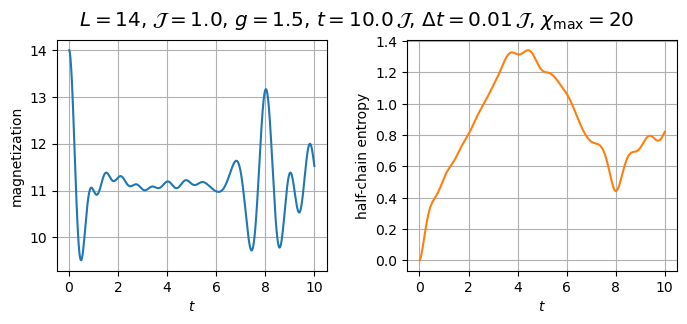

In [19]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
chi_max = 20
for dt in [1*J, 0.1*J, 0.01*J]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max, tebd_order=2)
    
    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

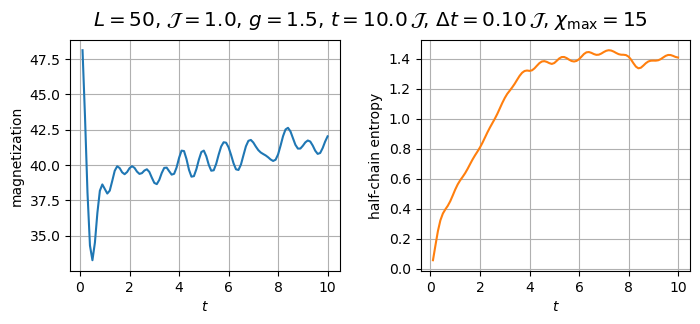

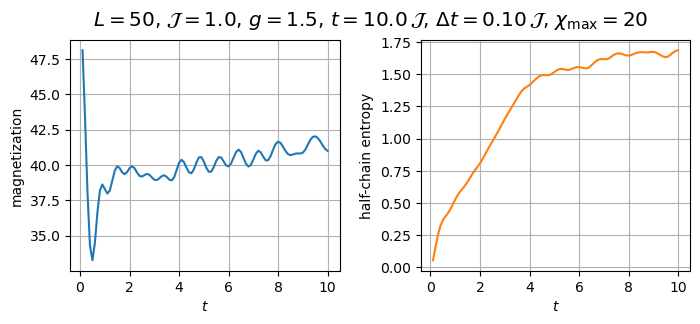

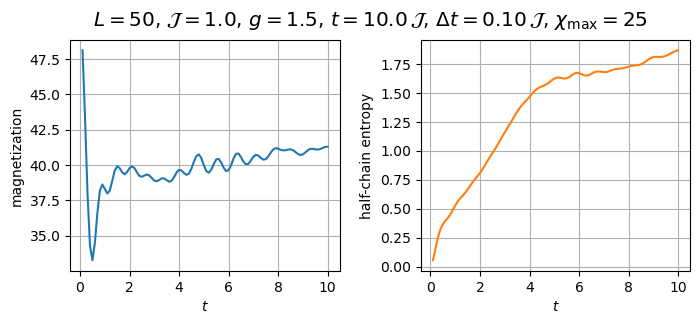

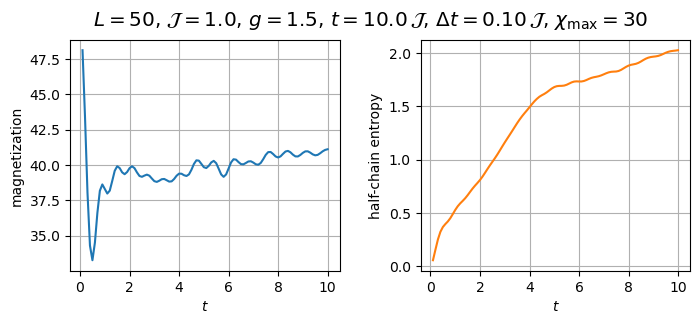

In [20]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
dt = 0.1*J
for chi_max in [15, 20, 25, 30]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max, tebd_order=2)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

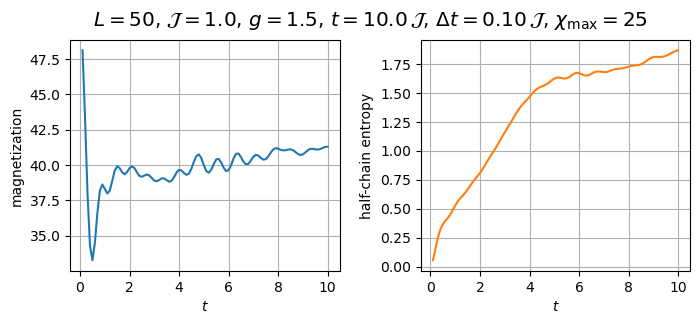

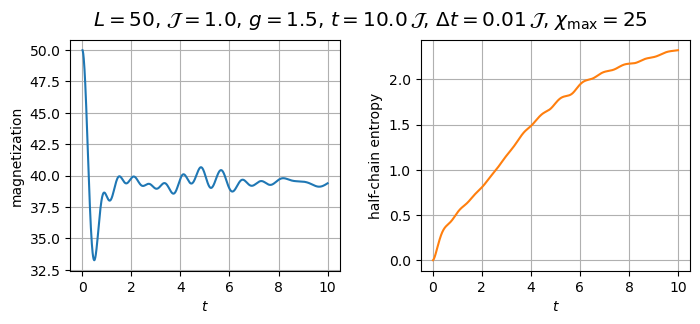

In [21]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)

t = 10*J
chi_max = 25
for dt in [0.1*J, 0.01*J]:
    spinup_mps = init_spinup_MPS(L)
    Ms, Ss = global_quench(spinup_mps, model, t, dt, chi_max, tebd_order=2)

    plot_global_quench(Ms, Ss[:, L//2], model, t, dt, chi_max)

**(h)**

In [22]:
def local_quench(psi, model, t, dt, chi_max, eps=1.e-10, tebd_order=1):
    
    assert tebd_order in [1, 2]

    U_bonds = calc_U_bonds(model, 1j*dt)
    N_steps = round(t/dt)
    op = model.sigmaz

    # apply sigma_x to the site at the center
    n0 = round(psi.L / 2)
    B_n0 = np.tensordot(psi.Bs[n0], model.sigmax, axes=[1, 1]) # vL [n0] vR, n0 [n0]
    psi.Bs[n0] = np.transpose(B_n0, axes=[0, 2, 1])

    if tebd_order == 1:
        Ms, Ss = run_TEBD1_and_measure(psi, op, U_bonds, N_steps, chi_max, eps)
    else:
        U_bonds_half_dt = calc_U_bonds(model, 1j*dt/2)
        Ms, Ss = run_TEBD2_and_measure(psi, op, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps)

    return Ms, Ss

In [23]:
def plot_local_quench(Ss, model, t, dt, chi_max):
    
    fig, ax = plt.subplots(1, 1)
    img = ax.imshow(Ss, origin='lower', aspect=0.05) #extent=[0, t_and_S.shape[1], 0, t_and_S.shape[0]], aspect=0.05)
    plt.colorbar(img, ax=ax, label='$S$')
    ax.set_xlabel('$n$'), ax.set_ylabel('$t$')
    ax.set_title('$L=%d$, $\mathcal{J}=%.1f$, $g=%.1f$, $t=%.1f\,\mathcal{J}$, $\Delta t=%.2f\,\mathcal{J}$, $\chi_{\mathrm{max}}=%d$'%(model.L, model.J, model.g, t, dt, chi_max));

In [24]:
# L, J, g = 14, 1, 1.5
# _, gs_mps, _ = example_TEBD_gs_finite(L, J, g)
# filename = 'exercise9_data/gs_L14.pkl'
# save(filename, gs_mps)


# L, J, g = 50, 1, 1.5
# _, gs_mps, _ = example_TEBD_gs_finite(L, J, g)
# filename = 'exercise9_data/gs_L50.pkl'
# save(filename, gs_mps)

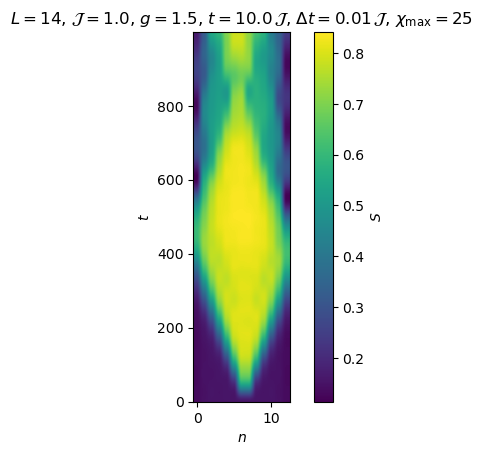

In [25]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)
gs_L14 = load('exercise9_data/gs_L14.pkl')
t = 10*J
dt = 0.01*J
chi_max = 25
_, Ss_L14_1st_order = local_quench(gs_L14, model, t, dt, chi_max, tebd_order=1)

plot_local_quench(Ss_L14_1st_order, model, t, dt, chi_max)

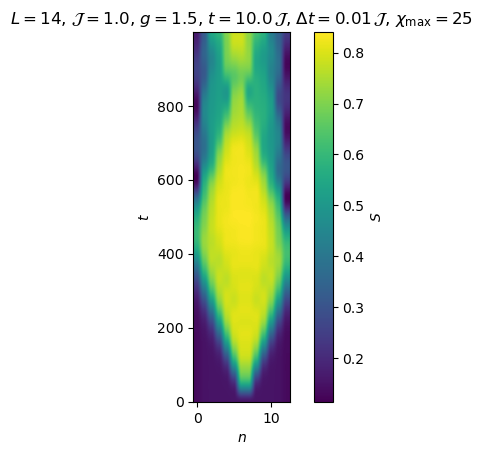

In [26]:
L, J, g = 14, 1, 1.5
model = TFIModel(L, J, g)
gs_L14 = load('exercise9_data/gs_L14.pkl')
t = 10*J
dt = 0.01*J
chi_max = 25
_, Ss_L14_2nd_order = local_quench(gs_L14, model, t, dt, chi_max, tebd_order=2)

plot_local_quench(Ss_L14_2nd_order, model, t, dt, chi_max)

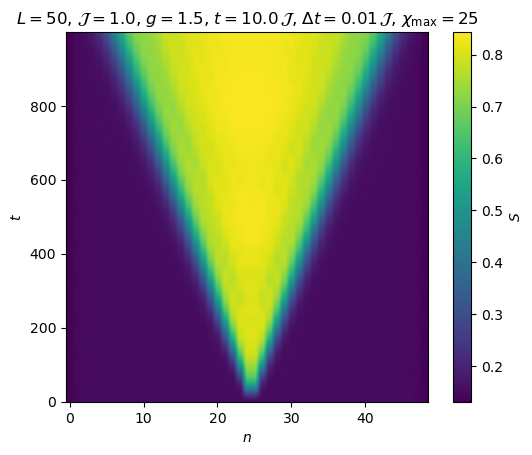

In [27]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)
gs_L50 = load('exercise9_data/gs_L50.pkl')
t = 10*J
dt = 0.01*J
chi_max = 25
_, Ss_L50_1st_order = local_quench(gs_L50, model, t, dt, chi_max, tebd_order=1)

plot_local_quench(Ss_L50_1st_order, model, t, dt, chi_max)

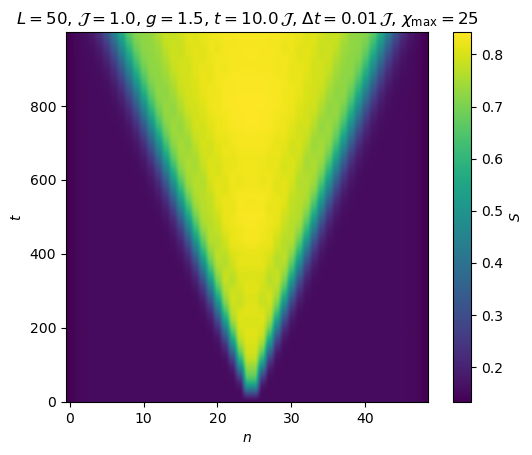

In [28]:
L, J, g = 50, 1, 1.5
model = TFIModel(L, J, g)
gs_L50 = load('exercise9_data/gs_L50.pkl')
t = 10*J
dt = 0.01*J
chi_max = 25
_, Ss_L50_2nd_order = local_quench(gs_L50, model, t, dt, chi_max, tebd_order=2)

plot_local_quench(Ss_L50_2nd_order, model, t, dt, chi_max)

In [29]:
save('exercise9_data/Ss_L14_1st_order.pkl', Ss_L14_1st_order)
save('exercise9_data/Ss_L14_2nd_order.pkl', Ss_L14_2nd_order)
save('exercise9_data/Ss_L50_1st_order.pkl', Ss_L50_1st_order)
save('exercise9_data/Ss_L50_2nd_order.pkl', Ss_L50_2nd_order)